# Audio reconstruction with spikes and MFCCs

In [ ]:
!pip install pydub
!pip install snnTorch

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from snntorch import spikegen
import snntorch.spikeplot as splt
from pydub import AudioSegment
from IPython.display import HTML

##Loading sound

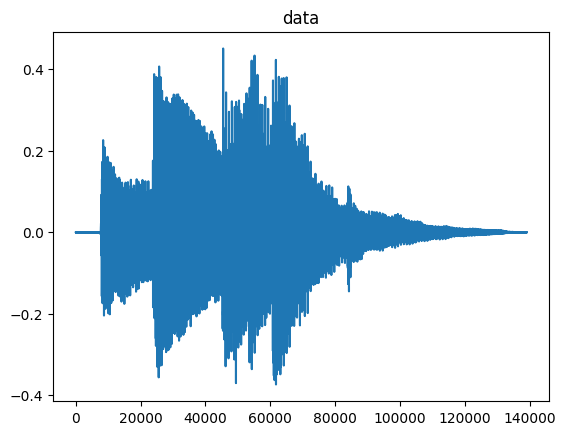

In [ ]:
data, rate = librosa.load("./piano2.wav")

def show_data(data):
    plt.figure()
    plt.title("data")
    plt.plot(data)
    plt.show()

show_data(data)
ipd.Audio(data, rate=22050)

## Transforming in MFCC

before transform  [-599.0974  -598.27545 -598.27075 -598.1067  -598.47766 -598.4747
 -598.40436 -598.3007  -598.1851  -598.85114]


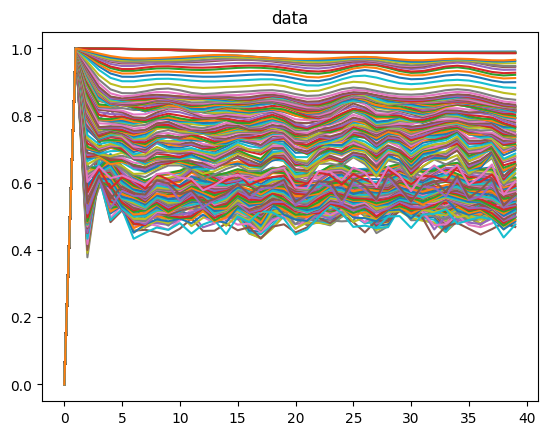

mfcc shape  (40, 272)


In [ ]:
data = librosa.feature.mfcc(y=data, sr=rate, n_mfcc = 40)
print('before transform ', data[0][:10])
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(data)
data = scaler.transform(data)

show_data(data)
print('mfcc shape ', data.shape)

## Reconstructing the audio based only on the MFCC

after inverse transform  [-599.0974  -598.27545 -598.27075 -598.1067  -598.47766 -598.4747
 -598.40436 -598.3007  -598.1851  -598.85114]


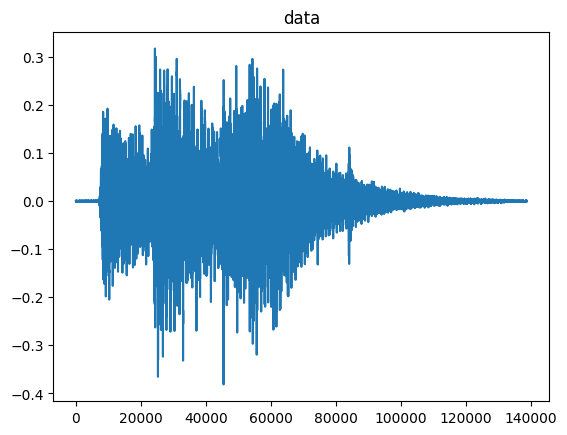

<_io.BufferedRandom name='/content/piano_mfcc_reconstruction.wav'>

In [ ]:
data = scaler.inverse_transform(data)

print('after inverse transform ', data[0][:10])

wav = librosa.feature.inverse.mfcc_to_audio(data)
show_data(wav)

ipd.Audio(wav, rate=22050)

final = ipd.Audio(wav, rate=22050)
final = AudioSegment(final.data, frame_rate=22050, sample_width=2, channels=1)
final.export('/content/piano_mfcc_reconstruction.wav', format="wav", bitrate="64k")


## Now we try to encode the data with rate and latency encoding and then reconstruct the audio

In [ ]:
def reconstruct(data):
  timestep = data.shape[0]
  neurons_spike = data[1]
  spike_per_neuron = torch.sum(data, dim = 0)
  res = spike_per_neuron/timestep
  return res.reshape(data.shape[1:])


def reconstruct_latency(data):
  timestep = data.shape[0]
  neurons_spike = data[1]
  res = torch.zeros(data.shape[1:])
  for t in range(timestep):
    for i in range(data[t].shape[0]):
      for j in range(data[t].shape[1]):
        if data[t,i,j] != 0:
          res[i,j] = 1 - (t/timestep)
  return res.reshape(data.shape[1:])

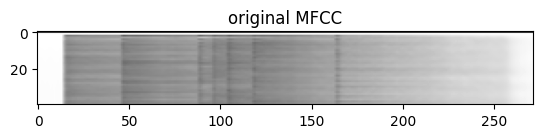

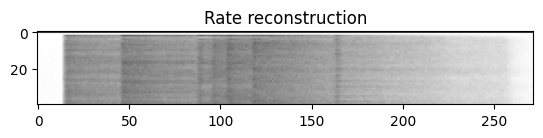

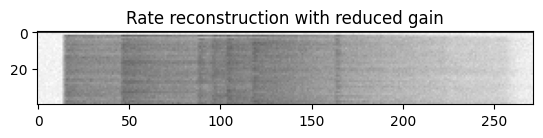

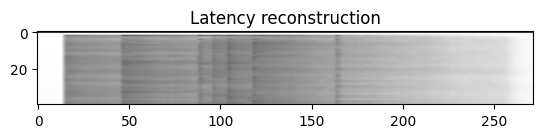

<Figure size 640x480 with 0 Axes>

In [ ]:
data, rate = librosa.load("/content/drive/MyDrive/PER_dataset/piano2.wav")
original_data, _ = librosa.load("/content/drive/MyDrive/PER_dataset/piano2.wav")

data = librosa.feature.mfcc(y=data, sr=rate, n_mfcc = 40)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(data)
data = scaler.transform(data)
data = torch.from_numpy(data)
data = data/torch.max(data)

train_loader = DataLoader(data, batch_size=1, shuffle=True)

num_steps = 1000
spike_data_rate = spikegen.rate(data, num_steps=num_steps)

num_steps = 1000
spike_data_rate_2 = spikegen.rate(data, num_steps=num_steps,gain=0.75) #Modifying the spiking requisite (neuron less likely to fire)

num_steps = 200
spike_data_latency = spikegen.latency(data, num_steps=num_steps, normalize = True, linear = True) #To better reconstruct the data, we change the logarithmic depensecy of latency encoding into a linear dependency

new_data_rate = reconstruct(spike_data_rate)
new_data_rate_2 = reconstruct(spike_data_rate_2)
new_data_latency = reconstruct_latency(spike_data_latency)

plt.title("original MFCC")
plt.imshow(data.detach().numpy(), cmap = 'gray')
plt.figure()

plt.title("Rate reconstruction")
plt.imshow(new_data_rate.detach().numpy(), cmap = 'gray')
plt.figure()

plt.title("Rate reconstruction with reduced gain")
plt.imshow(new_data_rate_2.detach().numpy(), cmap = 'gray')
plt.figure()

plt.title("Latency reconstruction")
plt.imshow(new_data_latency.detach().numpy(), cmap = 'gray')
plt.figure()

new_data_rate = scaler.inverse_transform(new_data_rate)
new_data_rate = librosa.feature.inverse.mfcc_to_audio(new_data_rate)

new_data_rate_2 = scaler.inverse_transform(new_data_rate_2)
new_data_rate_2 = librosa.feature.inverse.mfcc_to_audio(new_data_rate_2)

new_data_latency = scaler.inverse_transform(new_data_latency)
new_data_latency = librosa.feature.inverse.mfcc_to_audio(new_data_latency)

ipd.Audio(original_data, rate=22050)

## Rate encoding through all time steps:

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_rate, fig, ax)

HTML(anim.to_html5_video())
#anim.save("piano_rate_spikes.mp4")

## Latency encoding through all time steps:

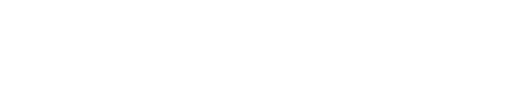

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_latency, fig, ax)


HTML(anim.to_html5_video())
#anim.save("piano_latency_spikes.mp4")

## Audio reconstructed with rate encoding

In [ ]:
ipd.Audio(new_data_rate, rate=22050)

## Audio reconstructed with rate encoding with less gain

In [ ]:
ipd.Audio(new_data_rate_2, rate=22050)

As we can hear, by modifying the gain in the rate encoding, the reconstruction is inaudible.

## Audio reconstructed with latency encoding

In [ ]:
ipd.Audio(new_data_latency, rate=22050)

In [ ]:
#Download the reconstructions

"""
final = ipd.Audio(original_data, rate=22050)
final = AudioSegment(final.data, frame_rate=22050, sample_width=2, channels=1)
final.export('/content/piano_original.wav', format="wav", bitrate="64k")


final = ipd.Audio(new_data_rate, rate=22050)
final = AudioSegment(final.data, frame_rate=22050, sample_width=2, channels=1)
final.export('/content/piano_rate_reconstruction.wav', format="wav", bitrate="64k")


final = ipd.Audio(new_data_rate_2, rate=22050)
final = AudioSegment(final.data, frame_rate=22050, sample_width=2, channels=1)
final.export('/content/piano_rate_2_reconstruction.wav', format="wav", bitrate="64k")


final = ipd.Audio(new_data_latency, rate=22050)
final = AudioSegment(final.data, frame_rate=22050, sample_width=2, channels=1)
final.export('/content/piano_latency_reconstruction.wav', format="wav", bitrate="64k")
"""


'\nfinal = ipd.Audio(original_data, rate=22050)\nfinal = AudioSegment(final.data, frame_rate=22050, sample_width=2, channels=1)\nfinal.export(\'/content/piano_original.wav\', format="wav", bitrate="64k")\n\n\nfinal = ipd.Audio(new_data_rate, rate=22050)\nfinal = AudioSegment(final.data, frame_rate=22050, sample_width=2, channels=1)\nfinal.export(\'/content/piano_rate_reconstruction.wav\', format="wav", bitrate="64k")\n\n\nfinal = ipd.Audio(new_data_rate_2, rate=22050)\nfinal = AudioSegment(final.data, frame_rate=22050, sample_width=2, channels=1)\nfinal.export(\'/content/piano_rate_2_reconstruction.wav\', format="wav", bitrate="64k")\n\n\nfinal = ipd.Audio(new_data_latency, rate=22050)\nfinal = AudioSegment(final.data, frame_rate=22050, sample_width=2, channels=1)\nfinal.export(\'/content/piano_latency_reconstruction.wav\', format="wav", bitrate="64k")\n'